In [2]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

In [24]:
def load_data():
    # 加载数据MNIST, 训练集和测试集(train=True/False), 转换为张量(附带归一化 /255), 下载数据
    train_data = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)
    
    # 数据加载器 DataLoader, 用于将数据分批次加载, shuffle=True表示打乱数据
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)
    return train_loader, test_loader

In [25]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 256)
        self.fc2 = torch.nn.Linear(256, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [26]:
def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(criterion(outputs, labels).item())
    
    return 100 * correct / total, test_loss

In [54]:
def train(model, train_loader, test_loader, optimizer, criterion, device):
    model.train()
    train_loss_all = []
    test_loss_all = []
    test_acc_all = []
    # 记录训练时间
    start_time = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # 优化器梯度清零
        optimizer.zero_grad()
        # 数据加载到设备
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        outputs = model(images)
        # 计算损失, 反向传播, 更新参数
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_all.append(loss.item())
        
        # 打印训练信息
        if (i+1) % 100 == 0:
            # 计算测试集准确率
            test_acc, test_loss = test(model, test_loader, criterion, device)
            test_loss_all.append(np.mean(test_loss))
            test_acc_all.append(test_acc)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.2f}%'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item(), np.mean(test_loss_all), test_acc))
    
    print("time used: {:.4f}".format(time.time()-start_time))    
    return train_loss_all, test_loss_all, test_acc_all   

In [55]:
# 开始训练, 使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

# 加载数据
train_loader, test_loader = load_data()
# 初始化模型, 损失函数, 优化器
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3

# 训练模型
train_loss_all = []
test_loss_all = []
test_acc_all = []
for epoch in range(num_epochs):
    train_loss, test_loss, test_acc = train(model, train_loader, test_loader, optimizer, criterion, device)
    train_loss_all.extend(train_loss)
    test_loss_all.extend(test_loss)
    test_acc_all.extend(test_acc)

device:  cpu
Epoch [1/3], Step [100/938], Loss: 1.6451, Test Loss: 1.6171, Test Acc: 88.28%
Epoch [1/3], Step [200/938], Loss: 1.5437, Test Loss: 1.5960, Test Acc: 90.51%
Epoch [1/3], Step [300/938], Loss: 1.5705, Test Loss: 1.5857, Test Acc: 90.98%
Epoch [1/3], Step [400/938], Loss: 1.5287, Test Loss: 1.5776, Test Acc: 91.78%
Epoch [1/3], Step [500/938], Loss: 1.5614, Test Loss: 1.5716, Test Acc: 92.25%
Epoch [1/3], Step [600/938], Loss: 1.5580, Test Loss: 1.5666, Test Acc: 92.76%
Epoch [1/3], Step [700/938], Loss: 1.5968, Test Loss: 1.5624, Test Acc: 93.15%
Epoch [1/3], Step [800/938], Loss: 1.5586, Test Loss: 1.5589, Test Acc: 93.43%
Epoch [1/3], Step [900/938], Loss: 1.5650, Test Loss: 1.5556, Test Acc: 93.92%
time used: 17.9912
Epoch [2/3], Step [100/938], Loss: 1.4962, Test Loss: 1.5242, Test Acc: 94.25%
Epoch [2/3], Step [200/938], Loss: 1.5221, Test Loss: 1.5232, Test Acc: 94.40%
Epoch [2/3], Step [300/938], Loss: 1.5799, Test Loss: 1.5232, Test Acc: 94.29%
Epoch [2/3], Step [4

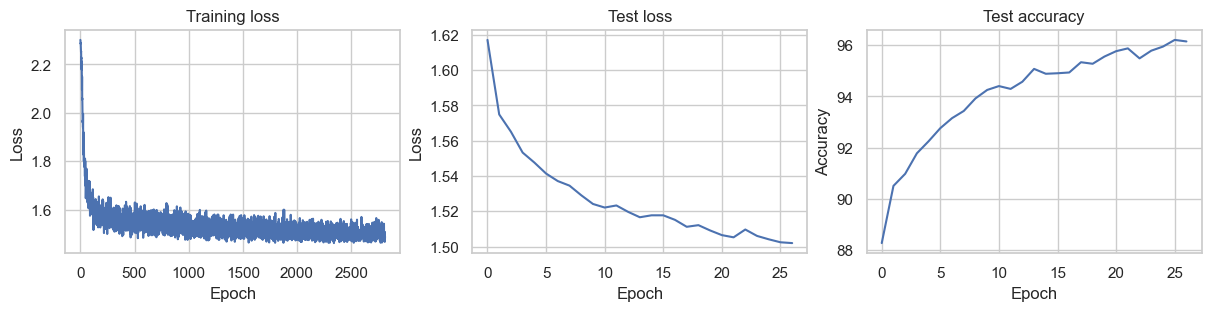

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制训练损失
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
sns.lineplot(x=range(len(train_loss_all)), y=train_loss_all)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

plt.subplot(1, 3, 2)
sns.lineplot(x=range(len(test_loss_all)), y=test_loss_all)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')

plt.subplot(1, 3, 3)
sns.lineplot(x=range(len(test_acc_all)), y=test_acc_all)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')

plt.show()

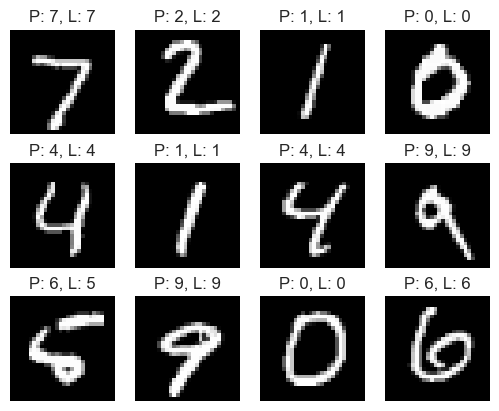

In [57]:
# 绘制实例
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

plt.figure(figsize=(5, 4), constrained_layout=True)
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("P: %d, L: %d" % (predicted[i], labels[i]))
plt.show()